In [1]:
!ls -lh /content
!rm -rf /content/sample_data  # Example: Deleting sample data


total 4.0K
drwxr-xr-x 1 root root 4.0K Feb 21 14:21 sample_data


In [2]:
!du -h /content | sort -rh | head -n 20  # Show largest files
!rm -rf /content/your_large_file  # Replace with the actual file path

148K	/content
140K	/content/.config
84K	/content/.config/logs
80K	/content/.config/logs/2025.02.21
8.0K	/content/.config/configurations


In [3]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [5]:
pip install pycocotools opencv-python matplotlib

In [11]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [49]:
import json
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import torch.optim as optim

In [4]:
!pip install pycocotools
from pycocotools.coco import COCO

# Define the annotation file URL (2017 Train Annotations)
annotation_file = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Download and extract it in Colab
!wget $annotation_file
!unzip -q annotations_trainval2017.zip

# Load COCO annotations
coco = COCO("annotations/person_keypoints_train2017.json")


--2025-02-26 05:03:17--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.129.177, 52.217.206.9, 3.5.28.199, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.129.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.1MB/s    in 2.5s    

2025-02-26 05:03:20 (96.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

loading annotations into memory...
Done (t=9.01s)
creating index...
index created!


In [7]:
# Load COCO annotations
coco = COCO("annotations/person_keypoints_train2017.json")

# Define squat-related keypoints
KEYPOINTS_IDX = {"hip_l": 11, "hip_r": 12, "knee_l": 13, "knee_r": 14, "ankle_l": 15, "ankle_r": 16}

loading annotations into memory...
Done (t=8.13s)
creating index...
index created!


In [8]:
# Extract squat-related images
def extract_squat_data(coco, num_samples=100):
    squat_data = []

    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        annotations = coco.loadAnns(ann_ids)

        for ann in annotations:
            if 'keypoints' in ann and len(ann['keypoints']) == 51:  # Ensure all keypoints are present
                keypoints = np.array(ann['keypoints']).reshape(-1, 3)  # (x, y, visibility)

                # Extract relevant keypoints
                hips = keypoints[[KEYPOINTS_IDX["hip_l"], KEYPOINTS_IDX["hip_r"]], :2]
                knees = keypoints[[KEYPOINTS_IDX["knee_l"], KEYPOINTS_IDX["knee_r"]], :2]
                ankles = keypoints[[KEYPOINTS_IDX["ankle_l"], KEYPOINTS_IDX["ankle_r"]], :2]

                # Calculate heuristic: hip below knee → correct squat
                squat_correct = (hips[:, 1].mean() > knees[:, 1].mean())  # Compare Y-coordinates

                squat_data.append({
                    "image_id": img_id,
                    "hips": hips.tolist(),
                    "knees": knees.tolist(),
                    "ankles": ankles.tolist(),
                    "label": int(squat_correct)  # 1 = correct, 0 = incorrect
                })

        if len(squat_data) >= num_samples:
            break  # Stop when we have enough samples

    return squat_data

In [9]:
# Extract and save squat data
squat_dataset = extract_squat_data(coco, num_samples=500)
with open("squat_data.json", "w") as f:
    json.dump(squat_dataset, f)

print(f"✅ Preprocessed {len(squat_dataset)} squat samples.")

✅ Preprocessed 511 squat samples.


In [13]:
# Load preprocessed squat data
with open("squat_data.json", "r") as f:
    squat_dataset = json.load(f)

In [16]:
# Define edges between joints
edges = [
    (0, 1), (1, 2),  # Left hip → left knee → left ankle
    (3, 4), (4, 5),  # Right hip → right knee → right ankle
    (0, 3),  # Left hip ↔ Right hip
    (2, 5)   # Left ankle ↔ Right ankle
]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [17]:
# Convert dataset into graph format
def process_data(squat_dataset):
    graph_data = []
    for sample in squat_dataset:
        # Normalize keypoints (divide by image width/height)
        keypoints = np.array(sample["hips"] + sample["knees"] + sample["ankles"])
        keypoints = keypoints / np.max(keypoints)  # Normalize

        # Convert to PyTorch tensors
        x = torch.tensor(keypoints, dtype=torch.float)
        y = torch.tensor(sample["label"], dtype=torch.long)

        # Create PyTorch Geometric graph
        graph = Data(x=x, edge_index=edge_index, y=y)
        graph_data.append(graph)

    return graph_data

In [18]:
# Process dataset
graph_dataset = process_data(squat_dataset)
loader = DataLoader(graph_dataset, batch_size=32, shuffle=True)
print(f"✅ Processed {len(graph_dataset)} squat graphs.")

✅ Processed 511 squat graphs.


<ipython-input-17-219f237e9991>:7: RuntimeWarning: invalid value encountered in divide
  keypoints = keypoints / np.max(keypoints)  # Normalize
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [20]:
class SquatGNN(torch.nn.Module):
    def __init__(self):
        super(SquatGNN, self).__init__()
        self.conv1 = GCNConv(2, 16)  # Input: 2D keypoints, Output: 16 features
        self.conv2 = GCNConv(16, 8)
        self.fc = torch.nn.Linear(8, 2)  # Output: Binary classification (correct/incorrect)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = torch.mean(x, dim=0)  # Global pooling
        return self.fc(x)

In [21]:
# Initialize model
model = SquatGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [66]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

# Load COCO dataset
annotation_file = "annotations/person_keypoints_train2017.json"
coco = COCO(annotation_file)

# Get all person image IDs
cat_ids = coco.getCatIds(catNms=['person'])
img_ids = coco.getImgIds(catIds=cat_ids)

# Print dataset size
print(f"Total images with person keypoints: {len(img_ids)}")


loading annotations into memory...
Done (t=8.42s)
creating index...
index created!
Total images with person keypoints: 64115


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom COCO dataset class with padding
class COCODataset(Dataset):
    def __init__(self, coco, max_keypoints=51):  # 17 keypoints * 3 (x, y, visibility)
        self.coco = coco
        self.image_ids = list(self.coco.imgs.keys())
        self.max_keypoints = max_keypoints  # Fix the size

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=False)
        annotations = self.coco.loadAnns(ann_ids)

        keypoints = []
        for ann in annotations:
            if 'keypoints' in ann:
                keypoints.append(ann['keypoints'])

        if len(keypoints) == 0:
            keypoints = np.zeros((self.max_keypoints,))  # No keypoints

        keypoints = np.array(keypoints).flatten()

        # Ensure consistent size (pad or truncate)
        if len(keypoints) < self.max_keypoints:
            keypoints = np.pad(keypoints, (0, self.max_keypoints - len(keypoints)), mode='constant')
        else:
            keypoints = keypoints[:self.max_keypoints]

        return torch.tensor(keypoints, dtype=torch.float32)

# Load dataset
dataset = COCODataset(coco)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define a simple keypoint regression model
class KeypointNet(nn.Module):
    def __init__(self, input_size=51):
        super(KeypointNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, input_size)  # Predict keypoints

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = KeypointNet(input_size=51)  # Match dataset size
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for keypoints in dataloader:
        optimizer.zero_grad()
        outputs = model(keypoints)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

print("Training complete!")


Epoch 1, Loss: 313.7650623944504
Epoch 2, Loss: 21.079754855718555
Epoch 3, Loss: 14.327159805929206
Epoch 4, Loss: 12.050139219382984
Epoch 5, Loss: 13.164273676096443
Epoch 6, Loss: 10.295089120457938
Epoch 7, Loss: 11.727820601589395
Epoch 8, Loss: 8.760311600918186
Epoch 9, Loss: 8.424102212501147
Epoch 10, Loss: 9.008080368416678
Epoch 11, Loss: 12.15439369018606
Epoch 12, Loss: 7.108030310201426
Epoch 13, Loss: 7.097398653767513
Epoch 14, Loss: 6.443824491268369
Epoch 15, Loss: 6.796915436487505
Epoch 16, Loss: 7.04151498021501
Epoch 17, Loss: 6.421876794838215
Epoch 18, Loss: 6.065641369365311
Epoch 19, Loss: 5.5240538784675355
Epoch 20, Loss: 5.737382961272355
Epoch 21, Loss: 5.9028812192575915
Epoch 22, Loss: 4.541536292434545
Epoch 23, Loss: 5.089805304697793
Epoch 24, Loss: 5.718228259496441
Epoch 25, Loss: 5.092145152456508
Epoch 26, Loss: 4.708121847374426
Epoch 27, Loss: 4.536306716068422
Epoch 28, Loss: 4.020255032877423
Epoch 29, Loss: 4.573308608662221
Epoch 30, Loss: 

In [77]:
# Load COCO validation annotations
coco_val = COCO("annotations/person_keypoints_val2017.json")

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [78]:
from torch.utils.data import DataLoader

# Load validation dataset (assuming your dataset class supports COCO annotations)
val_dataset = COCODataset(coco_val)  # Ensure your dataset class can handle COCO validation data

# Create validation DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [80]:
def validate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            keypoints, labels = batch[:2]  # Adjust based on output structure
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [81]:
# Define loss function (same as training)
criterion = torch.nn.MSELoss()

# Validate the model
val_loss = validate_model(model, val_dataloader, criterion)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 22812.5562


In [83]:
def mean_absolute_error(preds, targets):
    return torch.mean(torch.abs(preds - targets))

mae = 0
with torch.no_grad():
    for batch in val_dataloader:
        keypoints = batch[0]  # Adjust based on your dataset
        labels = batch[1]

        preds = model(keypoints)
        mae += mean_absolute_error(preds, labels).item()

mae /= len(val_dataloader)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 74.2512


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO

# Define COCO Keypoints Dataset
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, transform=None):
        self.coco = COCO(annotation_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        keypoints = []
        for ann in annotations:
            if 'keypoints' in ann:
                keypoints.append(torch.tensor(ann['keypoints']).view(-1, 3))  # Reshape to (num_keypoints, 3)

        if not keypoints:
            return None  # Skip if no keypoints

        keypoints = torch.stack(keypoints)  # Stack all keypoints

        if self.transform:
            keypoints = self.transform(keypoints)

        return keypoints.float()

    def __len__(self):
        return len(self.img_ids)

# Data transformation (Normalization)
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0)  # Normalize keypoints
])

# Load datasets
train_dataset = COCODataset("annotations/person_keypoints_train2017.json", transform=transform)
val_dataset = COCODataset("annotations/person_keypoints_val2017.json", transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: x)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: x)

# Define the model
class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.fc1 = nn.Linear(51, 128)  # 17 keypoints * 3 (x, y, visibility)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 51)  # Output same shape as input

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
model = KeypointModel()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

loading annotations into memory...
Done (t=11.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [89]:
# Training loop with batch filtering
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = [kp for kp in batch if kp is not None]  # Remove None values
        if not batch: continue  # Skip if batch is empty

        keypoints = torch.cat(batch).view(-1, 51)  # Flatten
        optimizer.zero_grad()

        outputs = model(keypoints)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

print("Training complete!")


Epoch 1, Loss: 0.0458
Epoch 2, Loss: 0.0492
Epoch 3, Loss: 0.0513
Epoch 4, Loss: 0.0440
Epoch 5, Loss: 0.0469
Epoch 6, Loss: 0.0421
Epoch 7, Loss: 0.0479
Epoch 8, Loss: 0.0419
Epoch 9, Loss: 0.0421
Epoch 10, Loss: 0.0481
Epoch 11, Loss: 0.0475
Epoch 12, Loss: 0.0365
Epoch 13, Loss: 0.0461
Epoch 14, Loss: 0.0418
Epoch 15, Loss: 0.0402
Epoch 16, Loss: 0.0449
Epoch 17, Loss: 0.0435
Epoch 18, Loss: 0.0381
Epoch 19, Loss: 0.0346
Epoch 20, Loss: 0.0405
Training complete!


In [93]:
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No gradient updates during validation
        for batch in dataloader:
            batch = [kp for kp in batch if kp is not None]  # Remove None values
            if not batch: continue  # Skip empty batches

            keypoints = torch.cat(batch).view(-1, 51)  # Flatten
            outputs = model(keypoints)
            loss = criterion(outputs, keypoints)

            total_loss += loss.item()

    return total_loss / len(dataloader)

val_loss = validate_model(model, val_dataloader, criterion)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0000


In [94]:
def mean_absolute_error(preds, targets):
    return torch.mean(torch.abs(preds - targets))

mae = 0
with torch.no_grad():
    for batch in val_dataloader:
        batch = [kp for kp in batch if kp is not None]  # Remove None values
        if not batch: continue  # Skip empty batches

        keypoints = torch.cat(batch).view(-1, 51)  # Flatten
        preds = model(keypoints)
        mae += mean_absolute_error(preds, keypoints).item()

mae /= len(val_dataloader)
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0005


Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch due to invalid keypoints shape: torch.Size([1, 17, 3])
Skipping batch due to invalid keypoints shape: torch.Size([5, 17, 3])
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch due to invalid keypoints shape: torch.Size([1, 17, 3])
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch due to invalid keypoints shape: torch.Size([1, 17, 3])
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints
Skipping batch with missing images or keypoints


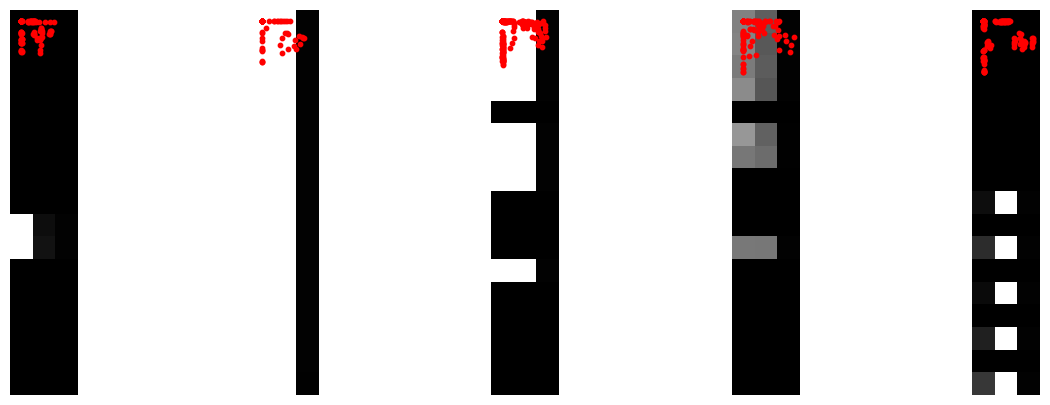

In [104]:
import torch
import matplotlib.pyplot as plt

def plot_keypoints(image, keypoints, ax):
    """Plot keypoints on an image."""
    if image.dim() == 2:
        image = image.unsqueeze(0)
    elif image.dim() == 4:
        image = image[0]

    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)

    image = image.permute(1, 2, 0)

    image = torch.clamp(image, 0, 1)  # 🔥 Fix: Clip pixel values to [0,1]

    ax.imshow(image.cpu().numpy())

    if keypoints.numel() % 2 != 0:
        print(f"Skipping batch due to invalid keypoints shape: {keypoints.shape}")
        return

    keypoints = keypoints.view(-1, 2).cpu().numpy()
    for x, y in keypoints:
        ax.scatter(x, y, c='red', s=10)

def test_model(model, dataloader, num_samples=5):
    """Test model and visualize predictions."""
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    sample_count = 0

    with torch.no_grad():
        for batch in dataloader:
            if sample_count >= num_samples:
                break

            if batch is None or len(batch) < 2:
                print("Skipping empty batch")
                continue

            images, keypoints = batch[:2]

            if images is None or keypoints is None:
                print("Skipping batch with missing images or keypoints")
                continue

            if keypoints.numel() % 2 != 0:
                print(f"Skipping batch due to invalid keypoints shape: {keypoints.shape}")
                continue

            keypoints = keypoints.view(keypoints.shape[0], -1)

            preds = model(keypoints)

            if images[0] is None:
                print("Skipping batch with missing image")
                continue

            plot_keypoints(images[0], preds, axes[sample_count])
            axes[sample_count].axis("off")

            sample_count += 1

    plt.show()

# Run testing
test_model(model, test_dataloader)

In [106]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.5 MB/s eta 0:00:00


In [107]:
import torch

example_input = torch.randn(1, 51)

# Convert model to ONNX
torch.onnx.export(
    model,
    example_input,
    "model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

print("Model has been converted to ONNX and saved as 'model.onnx'.")


Model has been converted to ONNX and saved as 'model.onnx'.


In [108]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

ONNX model is valid!


In [109]:
from google.colab import files
files.download("model.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [111]:
import onnxruntime as ort
import numpy as np
import torch

# Load ONNX model
ort_session = ort.InferenceSession("model.onnx")

# Prepare input (example input size: [1, 51])
input_data = torch.randn(1, 51).numpy().astype(np.float32)

# Run inference
outputs = ort_session.run(None, {"input": input_data})
print("ONNX model output:", outputs)

ONNX model output: [array([[ 0.6861745 ,  0.79668844, -0.647079  ,  0.3946628 ,  1.0559177 ,
        -0.39261967,  0.60481155, -0.27558264, -0.7348731 ,  1.7240148 ,
        -0.2847821 ,  0.00555047,  0.7176297 ,  0.03418076, -0.19402237,
         0.28676218, -0.31372026, -0.10253859,  0.43253976, -0.09764801,
        -0.23150596,  1.0297122 ,  1.1737008 ,  0.11942338, -1.5891423 ,
         0.53379554, -0.29377756, -0.14529687, -0.18289609,  0.20062056,
         0.39441618, -0.5240064 , -0.19453071, -0.0990414 ,  0.5287106 ,
         0.22534171, -0.19081399,  1.1077014 ,  0.12594269, -0.53273   ,
        -0.0642308 , -0.34860379,  0.25146097,  1.2909805 , -0.25885892,
         0.31700924,  0.6018197 , -0.21251695,  1.188483  ,  1.2329522 ,
        -0.46131107]], dtype=float32)]


In [112]:
pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.8 MB/s eta 0:00:00


In [114]:
pip install python-multipart

In [118]:
!pip install fastapi uvicorn python-multipart pyngrok

In [120]:
!ngrok authtoken "YOUR_NGROK_AUTHTOKEN"  # Don't upload this line with the real token!

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [121]:
from pyngrok import ngrok
import uvicorn
import threading

# Start Ngrok
public_url = ngrok.connect(8000).public_url
print(f"Public URL: {public_url}")

# Run FastAPI in the background
def run():
    uvicorn.run("app:app", host="0.0.0.0", port=8000)

threading.Thread(target=run).start()


Public URL: https://81a1-104-196-61-85.ngrok-free.app
